In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import cv2
import tensorflow as tf
import keras
import glob
import os
from PIL import Image, ImageDraw
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
# Filtering warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

In [2]:
# Paths of test, train, and valid files
test_path = "C:/Users/Lavanya/Desktop/CreatED/img_analysis/test"
train_path = "C:/Users/Lavanya/Desktop/CreatED/img_analysis/train"
val_path = 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/valid'

In [3]:
# Paths for CSV files from each folder
train_csv_path = os.path.join(train_path, '_annotations.csv')
test_csv_path = os.path.join(test_path, '_annotations.csv')
val_csv_path = os.path.join(val_path, '_annotations.csv')

# Read CSV files
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
df_val = pd.read_csv(val_csv_path)

## Data Preprocessing

In [4]:
# Function to process images and save them with class name

def process_images(df, folder_path):
    # Create a new folder within the original folder to save images with bounding boxes
    new_folder_path = os.path.join(folder_path, "processed_imgs")
    os.makedirs(new_folder_path, exist_ok=True)

    for index, row in df.iterrows():
        image_path = os.path.join(folder_path, row['filename'])
        class_name = row['class']
        y_min, y_max, x_min, x_max = row['ymin'], row['ymax'], row['xmin'], row['xmax']

        # Open the image using PIL
        with Image.open(image_path) as img:
            # Draw a bounding box using the coordinates
            draw = ImageDraw.Draw(img)
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

            image=cv2.imread(image_path)
            image = cv2.resize(image, (224,224))  # Resize image to the required size
    
            # Create a new filename using the class name and the original file name
            new_filename = f"{class_name}_{os.path.basename(image_path)}"
            
            # Extract the prefix from the new filename
            prefix = new_filename.split('_')[0]
            
            # Create a subfolder for the prefix within the processed_imgs folder
            prefix_folder_path = os.path.join(new_folder_path, prefix)
            os.makedirs(prefix_folder_path, exist_ok=True)
            
            # Define the path for saving the processed image
            new_image_path = os.path.join(prefix_folder_path, new_filename)
            
            # Save the image with bounding box in the new folder
            img.save(new_image_path)
    
    # Use glob to collect all images in the new folder after processing
    folder_class = glob.glob(os.path.join(new_folder_path, "**", "*.jpg"), recursive=True)  # Adjust the extension if different
    
    return folder_class

In [5]:
# Process images for each folder
train_class = process_images(df_train, train_path)
test_class = process_images(df_test, test_path)
val_class = process_images(df_val, val_path)

In [6]:
# Print to verify results
print(f"Processed {len(train_class)} training images.")
print(f"Processed {len(test_class)} test images.")
print(f"Processed {len(val_class)} validation images.")

Processed 1385 training images.
Processed 167 test images.
Processed 339 validation images.


In [7]:
# Retrieve list of items
def classify(processed_images):

    # Dictionary to hold lists by prefix
    items_dict = {}
    
    # Iterate through each item in the list
    for item in processed_images:
        # Split each item to extract the prefix
        prefix = item.split('\\')[2].split('_')[0]
        
        # Construct the key name for the dictionary
        issue = f"train_{prefix}"
        
        # Initialize the list if the key does not exist
        if issue not in items_dict:
            items_dict[issue] = []
        
        # Append the item to the corresponding list in the dictionary
        items_dict[issue].append(item)
    
    # Display the results
    for key, value in items_dict.items():
        print(f"{key}: {value}")
    return items_dict

In [8]:
train_dict= classify(train_class)
test_dict= classify(test_class)
val_dict= classify(val_class)

train_artefact: ['C:/Users/Lavanya/Desktop/CreatED/img_analysis/train\\processed_imgs\\artefact\\artefact_image1_png_jpg.rf.18f8fc91ca76f8b311f5f3d3c828d30b.jpg', 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/train\\processed_imgs\\artefact\\artefact_image1_png_jpg.rf.766048100b9b30d799e755bbfcb571a0.jpg', 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/train\\processed_imgs\\artefact\\artefact_image1_png_jpg.rf.fbca13ce65898824bd75df09cc6de892.jpg', 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/train\\processed_imgs\\artefact\\artefact_image2_png_jpg.rf.f7793cf154b1d682f64110b564c59a41.jpg', 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/train\\processed_imgs\\artefact\\artefact_image3_png_jpg.rf.dcb7c54d094daeaa4af98764167c04db.jpg']
train_distal phalanges: ['C:/Users/Lavanya/Desktop/CreatED/img_analysis/train\\processed_imgs\\distal phalanges\\distal phalanges_image1_png_jpg.rf.06fd374199ca29d2acd53b53fb4b8d78.jpg', 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/train\\processed_im

In [9]:
# Creating dataframes for each set
train_list=[]
for i in train_dict:
    train_links = train_dict[i]
    train_list+=([i.split('_')[1]]*len(train_links))

df_train = pd.DataFrame({'class': train_list, 'image': train_class})

test_list=[]
for i in test_dict:
    test_links = test_dict[i]
    test_list+=([i.split('_')[1]]*len(test_links))

df_test = pd.DataFrame({'class': test_list, 'image': test_class})


val_list=[]
for i in val_dict:
    val_links = val_dict[i]
    val_list+=([i.split('_')[1]]*len(val_links))

df_val = pd.DataFrame({'class': val_list, 'image': val_class})

In [10]:
# Created lists of Image and its corresponding Class
classes=[]
for i in train_dict:
    classes.append(i.split('_')[1])
length=[]
for i in range(0,len(classes)):
    length.append(i)

## Data Visualisation

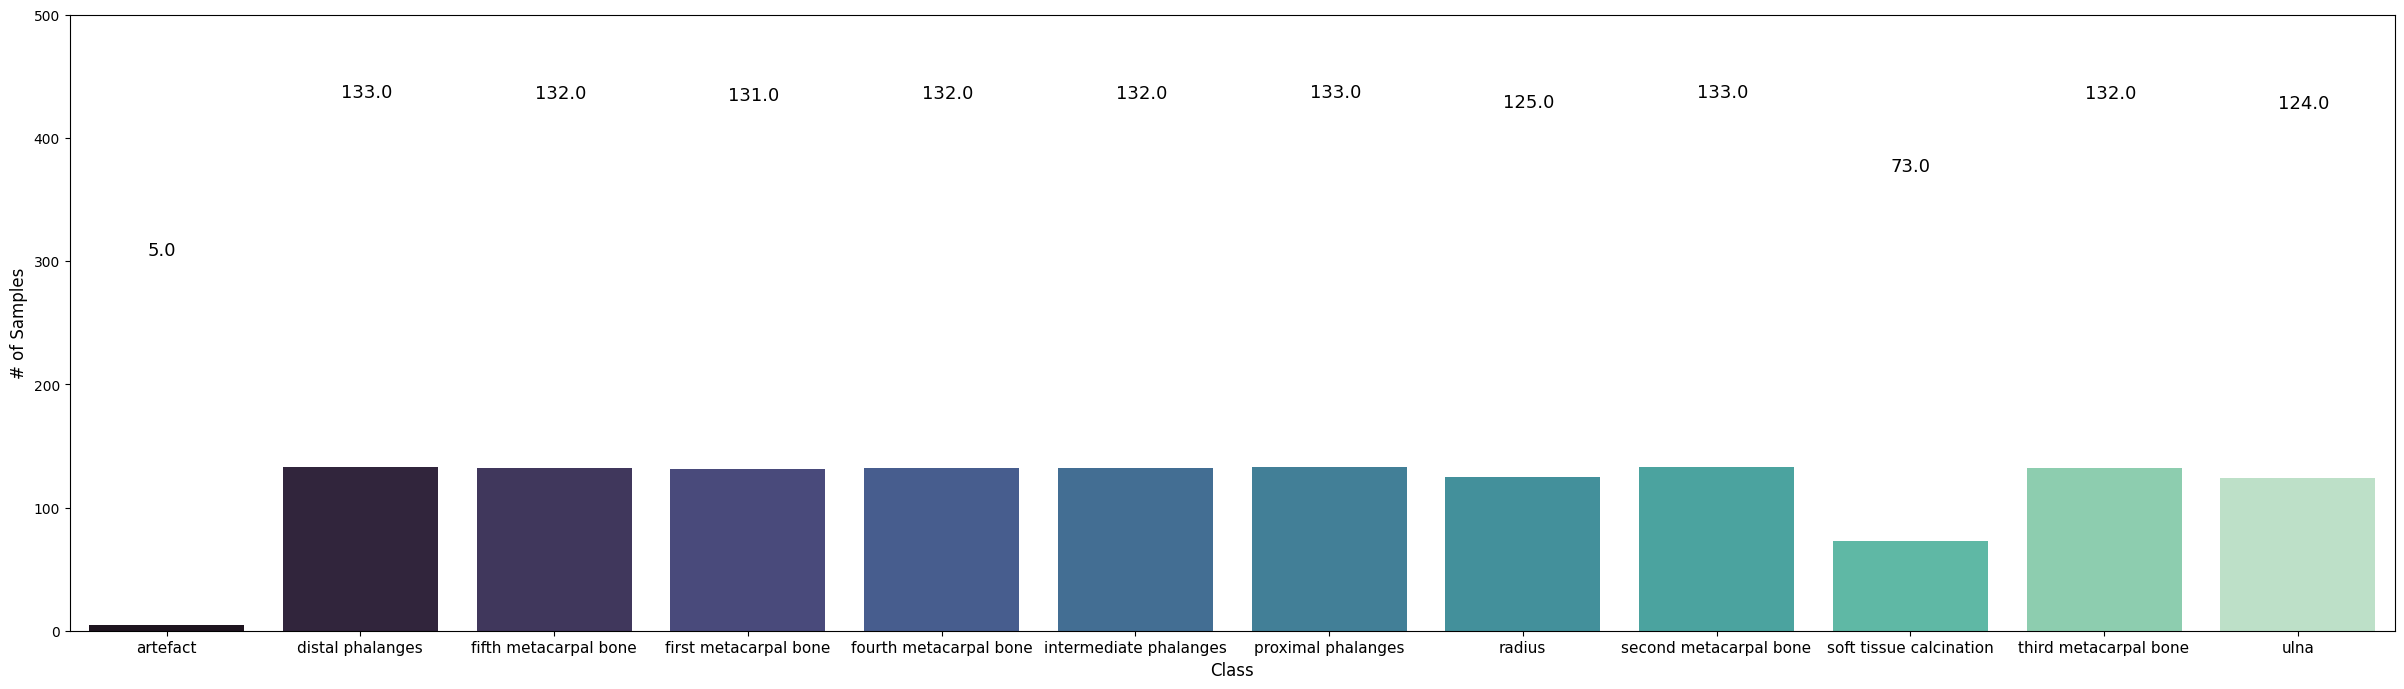

In [11]:
# Plotting the data
plt.figure(figsize=(30,8))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks(length, classes, fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

In [12]:
# Generating datasets by grayscaling and resizing them.
def generate_datasets(train_folder_path, val_folder_path, size=128, batch_size=32): 
    image_generator = ImageDataGenerator(
        samplewise_center=True, 
        samplewise_std_normalization=True,
        validation_split=0.3
    )

    # Create training dataset
    train_data = image_generator.flow_from_directory(
        directory=train_folder_path,
        target_size=(size, size),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size,                                   
        shuffle=True,
        seed=123,
        subset='training'
    )

    # Create validation dataset
    val_data = image_generator.flow_from_directory(
        directory=val_folder_path,
        target_size=(size, size),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123,
        subset='validation'
    )

    return train_data, val_data


In [13]:
# Define paths to your folders
train_folder_path = 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/train/processed_imgs'
val_folder_path = 'C:/Users/Lavanya/Desktop/CreatED/img_analysis/test/processed_imgs'

# Generate datasets
train_data, val_data = generate_datasets(train_folder_path, val_folder_path, size=128, batch_size=32)


Found 977 images belonging to 12 classes.
Found 42 images belonging to 12 classes.


## Model Building

In [14]:
def cnn_model(train_data, val_data, epochs, size):
    # Building the model using Keras functional API
    print("----Building the model----")
    i = Input(shape=(size, size, 1))  # defining input
    x = BatchNormalization()(i)
    x = Conv2D(32, 3, activation='relu')(x)  # adding convolution layers
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(12, activation='softmax')(x)

    model = Model(i, x)
    model.summary()

    # Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer=Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience=5, 
                               restore_best_weights=True)
    
    # Update the ModelCheckpoint to use the .keras extension
    mc = ModelCheckpoint('cnn_model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    # Fit the model
    r = model.fit(train_data, 
                  validation_data=val_data, 
                  epochs=epochs, 
                  verbose=2,
                  batch_size=32,
                  callbacks=[early_stop, mc])

    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r, model, n_epochs

    

In [15]:
# Defining parameters
epochs = 40
r,model,n_epochs = cnn_model(train_data, val_data,epochs,128)

----Building the model----


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 1)         │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,544 (24.87 MB)

 Trainable params: 6,518,542 (24.87 MB)

 Non-trainable params: 2 (8.00 B)

----Training the network----
Epoch 1/40

Epoch 1: val_loss improved from inf to 2.42083, saving model to cnn_model.keras
31/31 - 43s - 1s/step - accuracy: 0.0716 - loss: 2.5238 - val_accuracy: 0.0952 - val_loss: 2.4208
Epoch 2/40

Epoch 2: val_loss did not improve from 2.42083
31/31 - 12s - 381ms/step - accuracy: 0.0829 - loss: 2.4379 - val_accuracy: 0.1190 - val_loss: 2.4213
Epoch 3/40

Epoch 3: val_loss improved from 2.42083 to 2.41521, saving model to cnn_model.keras
31/31 - 13s - 418ms/step - accuracy: 0.0931 - loss: 2.4178 - val_accuracy: 0.0952 - val_loss: 2.4152
Epoch 4/40

Epoch 4: val_loss improved from 2.41521 to 2.41036, saving model to cnn_model.keras
31/31 - 13s - 422ms/step - accuracy: 0.0983 - loss: 2.4130 - val_accuracy: 0.0952 - val_loss: 2.4104
Epoch 5/40

Epoch 5: val_loss improved from 2.41036 to 2.40934, saving model to cnn_model.keras
31/31 - 13s - 424ms/step - accuracy: 0.0972 - loss: 2.4187 - val_accuracy: 0.0952 - val_loss: 2.4093
Epoch 6/40

Epoch 6: val_loss 

In [19]:
# Printing model accuracy for train and test data

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.4906 - loss: 1.6540
Train Accuracy using CNN: 48.41%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2842 - loss: 2.0979
Test Accuracy using CNN: 28.57%


In [17]:
# Checking relationship of number of epochs with accuracy and validation
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

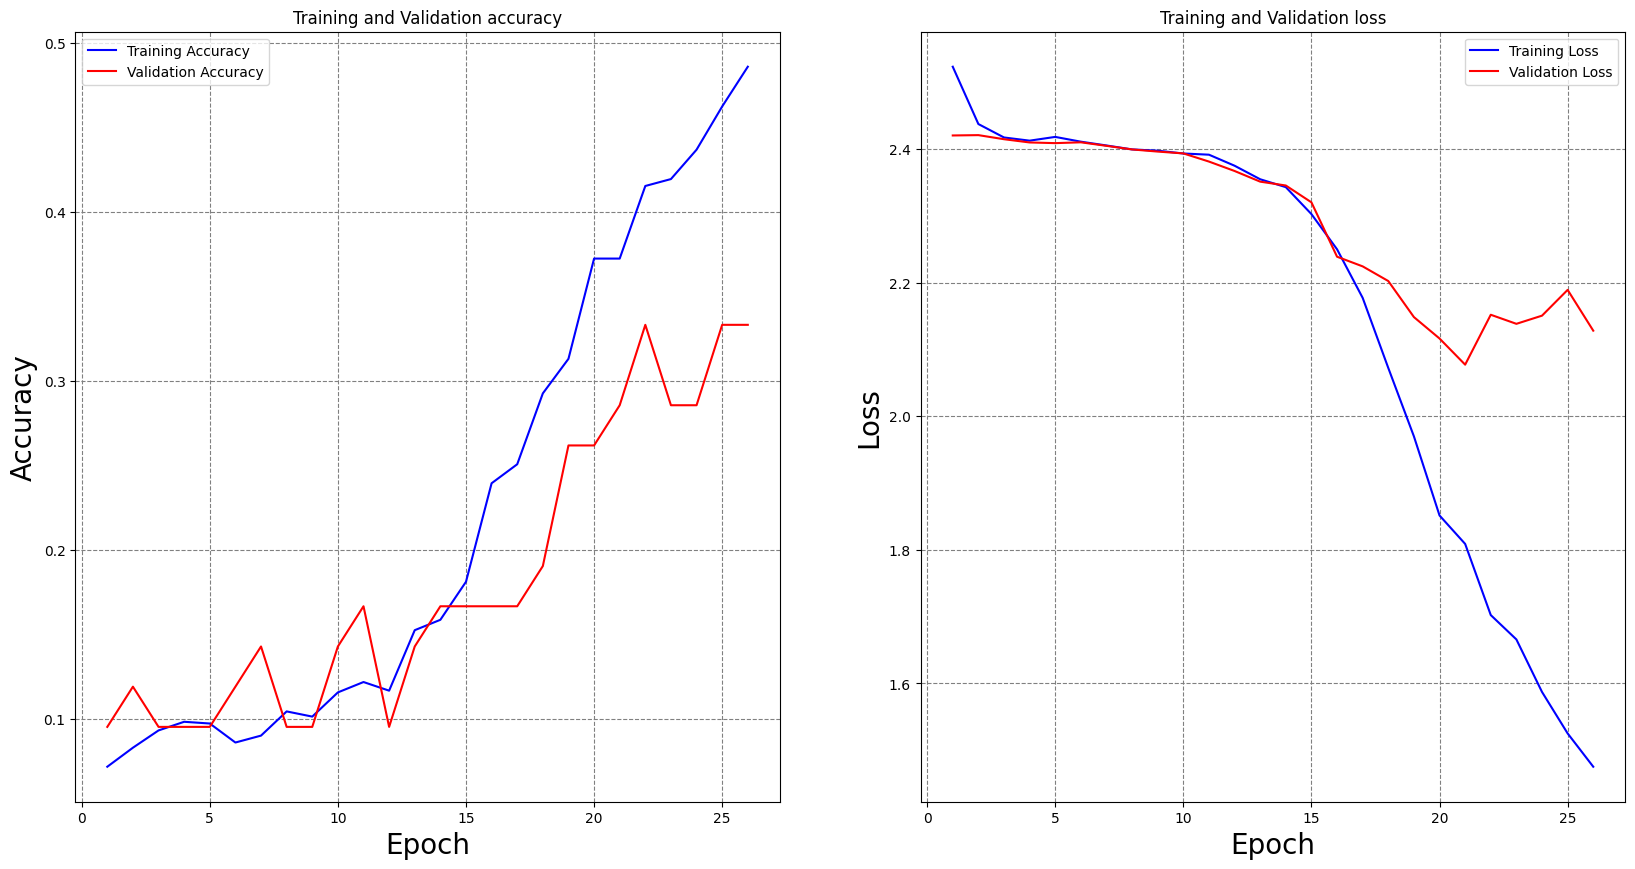

In [18]:
plotLearningCurve(r,n_epochs)

# Conclusions
## Observations 
* As number of epochs increase, accuracy also increases but not significantly.
* As number of epochs increase, validation loss decreases but no significant change is observed after 18 epochs.
* Through this learning curve it is observed that after 26 epochs the model cannot be trained further.

## Limitations
* The method used adds duplicates of the same data thus increasing complexity and redundancy during modelling.
* Segmentation adds one more inconsistent variable for model to learn during training i.e. the boxes added are not in the same place for all the images and all the classes.
* Therefore, alternate method should be explored.
* To control external sources of randomness and ensure consistency across runs we should add seed values for tensorflow, numpy and other environmental operations.
  
(Refer to codes folder in this repository for another method with improved accuracy).